In [1]:
import csv, toml
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def read_grid(gridfile, maxdepth=250):
    x1,y1,z1,x2,y2,z2,x3,y3,z3 = [],[],[], [],[],[], [],[],[]
    with open(gridfile, 'r') as f:
        csvreader = csv.reader(f)
        header = next(csvreader)
        for row in csvreader:
            if float(row[5])>maxdepth:
                continue;
            x1.append(float(row[0]))
            y1.append(float(row[1]))
            z1.append(float(row[2]))  
            x2.append(float(row[3]))
            y2.append(float(row[4]))
            z2.append(float(row[5]))  
            x3.append(float(row[6]))
            y3.append(float(row[7]))
            z3.append(float(row[8]))  
    return x1,y1,z1,x2,y2,z2,x3,y3,z3

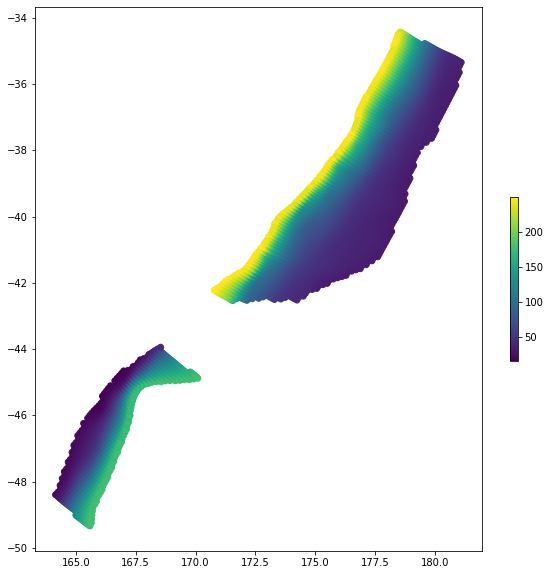

In [3]:
def view_grids(slabmodel=None):
    if slabmodel is None:
        slabmodel  = toml.load('../../components/slab_model/slab.ini')
    gridfile = {'hik': '../../'+slabmodel['hikurangi-slab']['file'],
            'puy': '../../'+slabmodel['puysegur-slab']['file']}
    # three models
    hx1,hy1,hz1,hx2,hy2,hz2,hx3,hy3,hz3 = read_grid(gridfile['hik'])
    px1,py1,pz1,px2,py2,pz2,px3,py3,pz3 = read_grid(gridfile['puy'], maxdepth=180)
    
    x2 = hx2+px2
    y2 = hy2+py2
    z2 = hz2+pz2
    
    # consider zmax=250
    #fig, axs = plt.subplots(1, 3, figsize=(8,3))
    #cb = axs[0].scatter(x1, y1, c=z1)
    #fig.colorbar(cb, ax =axs[0])
    #axs[1].scatter(x2, y2,c=z2)
    #axs[2].scatter(x3, y3,c=z3)
    #fig.tight_layout()
    plt.figure(figsize=(10,10))
    plt.scatter(x2,y2,c=z2)
    plt.colorbar(shrink=0.3)
    plt.show()

view_grids();


In [4]:
def write_ratefile(xx,yy,zz,rr, outfile):
    f = open(outfile,'w')
    f.write('lon,lat,dep,rate')
    for x,y,z,r in zip(xx,yy,zz,rr):
         f.write('\n%.4f,%.4f,%.3f,%.10f' %(x,y,z,r))
    f.close()

def read_ratefile(infile):
    x,y,z,r = [],[],[],[]
    with open(infile, 'r') as f:
        csvreader = csv.reader(f)
        header = next(csvreader)
        for row in csvreader:
            x.append(float(row[0]))
            y.append(float(row[1]))
            z.append(float(row[2]))  
            r.append(float(row[3]))
    return x,y,z,r 


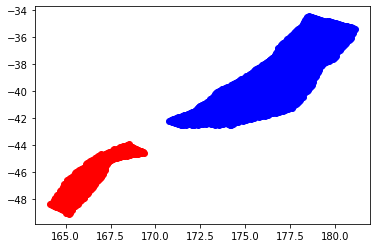

In [5]:
lon_p2, lat_p2, dep_p2, rate_p2 = read_ratefile('files/puy-slab-smooth_lay2.csv')
lon_h2, lat_h2, dep_h2, rate_h2 = read_ratefile('files/hik-slab-smooth_lay2.csv')

plt.plot(lon_p2, lat_p2, 'ro')
plt.plot(lon_h2, lat_h2, 'bo');

In [6]:

def write_floored_smooth(szone, maxdepth):
    outfolder = 'files/processed-smooth/'
    slabmodel  = toml.load('../../components/slab_model/slab.ini')
    gridfile = {'hik': '../../'+slabmodel['hikurangi-slab']['file'],
            'puy': '../../'+slabmodel['puysegur-slab']['file']}
    smoothratefile = {'hik': 'files/hik-slab-smooth_lay2.csv', 
                  'puy': 'files/puy-slab-smooth_lay2.csv'}

    if szone=='hik':
        w1,w2,w3 = slabmodel['hikurangi-slab']['weights']
    else:
        w1,w2,w3 = slabmodel['puysegur-slab']['weights']
    #
    lon_2, lat_2, dep_2, rate = read_ratefile(smoothratefile[szone])
    xx1,yy1,zz1,xx2,yy2,zz2,xx3,yy3,zz3 = read_grid(gridfile[szone])

    filenamekey = szone +'-slab-smooth_'
    f1 = open(outfolder+filenamekey+'lay1.csv', 'w')
    f2 = open(outfolder+filenamekey+'lay2.csv', 'w')
    f3 = open(outfolder+filenamekey+'lay3.csv', 'w')
    f4 = open(outfolder+filenamekey+'1depth.csv', 'w')

    klon, klat, kdep, krate = [],[],[],[]
    for x,y,z,r in zip(lon_2, lat_2, dep_2, rate):
        if z>maxdepth:
            continue
        klon.append(x)
        klat.append(y)
        kdep.append(z)
        krate.append(r)
    
    unirate = 1/len(krate)
    
    # floor the rates
    tkrate = []
    for r in krate:
        tkrate.append(max([r,unirate]))
    
    krate = [r/sum(tkrate) for r in tkrate]
   
    floored_krate = krate
    
    for x1,y1,z1,x2,y2,z2,x3,y3,z3 in zip(xx1,yy1,zz1,xx2,yy2,zz2,xx3,yy3,zz3):
        for x,y,z,r in zip(klon, klat, kdep, floored_krate):
            if z2>maxdepth:
                continue
            if (x2==x) & (y2==y): 
                f1.write('\n%.4f,%.4f,%.4f,%.10f' %(x1,y1,z1,r*w1))
                f2.write('\n%.4f,%.4f,%.4f,%.10f' %(x2,y2,z2,r*w2))
                f3.write('\n%.4f,%.4f,%.4f,%.10f' %(x3,y3,z3,r*w3))
                f4.write('\n%.4f,%.4f,%.4f,%.10f' %(x2,y2,z2,r))
    f1.close()
    f2.close()
    f3.close()
    f4.close()

In [7]:
maxdepth = 250
szone = 'hik'
write_floored_smooth(szone, maxdepth)

In [8]:
maxdepth = 150
szone = 'puy'
write_floored_smooth(szone, maxdepth)


In [9]:
"""
outfolder = 'files/processed-smooth/'
slabmodel  = toml.load('../../components/slab_model/slab.ini')
gridfile = {'hik': '../../'+slabmodel['hikurangi-slab']['file'],
            'puy': '../../'+slabmodel['puysegur-slab']['file']}

smoothratefile = {'hik': 'files/hik-slab-smooth_lay2.csv', 
                  'puy': 'files/puy-slab-smooth_lay2.csv'}
if szone=='hik':
    w1,w2,w3 = slabmodel['hikurangi-slab']['weights']
else:
    w1,w2,w3 = slabmodel['puysegur-slab']['weights']
#

lon_2, lat_2, dep_2, rate = read_ratefile(smoothratefile[szone])

xx1,yy1,zz1,xx2,yy2,zz2,xx3,yy3,zz3 = read_grid(gridfile[szone])

filenamekey = szone +'-slab-smooth_'
f1 = open(outfolder+filenamekey+'lay1.csv', 'w')
f2 = open(outfolder+filenamekey+'lay2.csv', 'w')
f3 = open(outfolder+filenamekey+'lay3.csv', 'w')
f4 = open(outfolder+filenamekey+'1depth.csv', 'w')

f1.write('lon,lat,dep,rate')
f2.write('lon,lat,dep,rate')
f3.write('lon,lat,dep,rate')
f4.write('lon,lat,dep,rate')

for x1,y1,z1,x2,y2,z2,x3,y3,z3 in zip(xx1,yy1,zz1,xx2,yy2,zz2,xx3,yy3,zz3):
    for x,y,z,r in zip(lon_2, lat_2, dep_2, rate):
        if z2>maxdepth:
            continue
        if (x2==x) & (y2==y):
            
            f1.write('\n%.4f,%.4f,%.4f,%.10f' %(x1,y1,z1,r*w1))
            f2.write('\n%.4f,%.4f,%.4f,%.10f' %(x2,y2,z2,r*w2))
            f3.write('\n%.4f,%.4f,%.4f,%.10f' %(x3,y3,z3,r*w3))
            f4.write('\n%.4f,%.4f,%.4f,%.10f' %(x2,y2,z2,r))
            
f1.close()
f2.close()
f3.close()
f4.close()
"""

"\noutfolder = 'files/processed-smooth/'\nslabmodel  = toml.load('../../components/slab_model/slab.ini')\ngridfile = {'hik': '../../'+slabmodel['hikurangi-slab']['file'],\n            'puy': '../../'+slabmodel['puysegur-slab']['file']}\n\nsmoothratefile = {'hik': 'files/hik-slab-smooth_lay2.csv', \n                  'puy': 'files/puy-slab-smooth_lay2.csv'}\nif szone=='hik':\n    w1,w2,w3 = slabmodel['hikurangi-slab']['weights']\nelse:\n    w1,w2,w3 = slabmodel['puysegur-slab']['weights']\n#\n\nlon_2, lat_2, dep_2, rate = read_ratefile(smoothratefile[szone])\n\nxx1,yy1,zz1,xx2,yy2,zz2,xx3,yy3,zz3 = read_grid(gridfile[szone])\n\nfilenamekey = szone +'-slab-smooth_'\nf1 = open(outfolder+filenamekey+'lay1.csv', 'w')\nf2 = open(outfolder+filenamekey+'lay2.csv', 'w')\nf3 = open(outfolder+filenamekey+'lay3.csv', 'w')\nf4 = open(outfolder+filenamekey+'1depth.csv', 'w')\n\nf1.write('lon,lat,dep,rate')\nf2.write('lon,lat,dep,rate')\nf3.write('lon,lat,dep,rate')\nf4.write('lon,lat,dep,rate')\n\nf